#Semantic segmentation

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>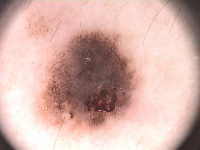</td><td>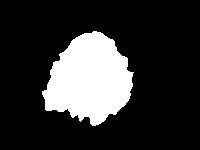</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar


--2024-01-10 14:05:05--  https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:601b:18::a27d:812
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/8lqrloi0mxj2acu/PH2Dataset.rar [following]
--2024-01-10 14:05:05--  https://www.dropbox.com/s/raw/8lqrloi0mxj2acu/PH2Dataset.rar
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc4ee80e6037c09056f5b8f407d2.dl.dropboxusercontent.com/cd/0/inline/CLG8GMC4JQqHo0kmyRDw66GtQNQCG3O8xUo3kBWy0MK69cQG1l-CwDFyVWMQhU2COD1nhbK4eihF1k6wlgy7GHED8xb3u6jOV5zBTmXa8HA6oT7YPtKUZUlIUUffSTAxKrY/file# [following]
--2024-01-10 14:05:05--  https://uc4ee80e6037c09056f5b8f407d2.dl.dropboxusercontent.com/cd/0/inline/CLG8GMC4JQqHo0kmyRDw66GtQNQCG3O8xUo3kBWy0MK69cQG1l-CwDFyVWMQhU2COD1nhbK4eihF1k6wlgy7GHED8xb3u6jOV5zBTmXa8HA6oT7YPtKUZ

In [ ]:
#! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar если вдруг не работает первая ссылка

In [ ]:
!ls

PH2Dataset.rar	sample_data


In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.



In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей.


In [ ]:
images[0]

array([[[211, 208, 193],
        [211, 209, 197],
        [211, 211, 203],
        ...,
        [211, 208, 199],
        [212, 209, 202],
        [212, 207, 201]],

       [[210, 208, 196],
        [207, 204, 197],
        [208, 207, 203],
        ...,
        [212, 208, 199],
        [214, 210, 201],
        [216, 209, 201]],

       [[213, 210, 203],
        [  5,   4,   0],
        [  1,   0,   0],
        ...,
        [ 37,  28,  31],
        [ 36,  25,  29],
        [ 35,  24,  28]],

       ...,

       [[211, 208, 199],
        [  3,   1,   2],
        [  0,   0,   2],
        ...,
        [ 37,  23,  22],
        [ 32,  21,  19],
        [ 28,  17,  15]],

       [[212, 209, 200],
        [  3,   1,   2],
        [  1,   0,   2],
        ...,
        [ 31,  23,  10],
        [ 29,  21,  10],
        [ 28,  20,   9]],

       [[211, 208, 199],
        [  2,   0,   1],
        [  1,   0,   2],
        ...,
        [ 21,  15,  17],
        [ 20,  14,  18],
        [ 21,  15,  19]]

In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

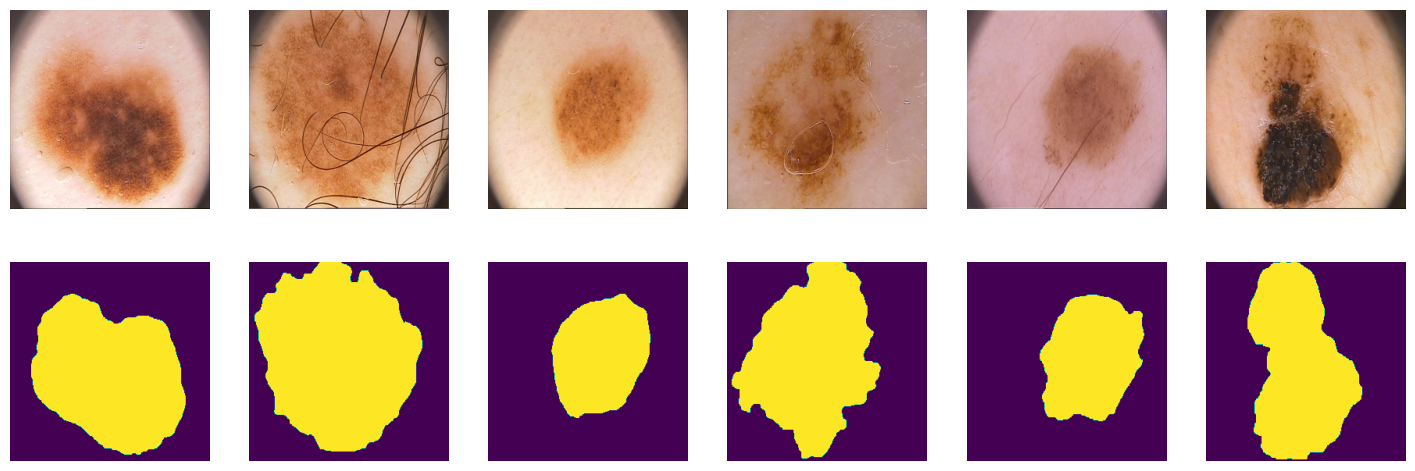

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 6
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


-----------------------------------------------------------------------------------------

# SegNet

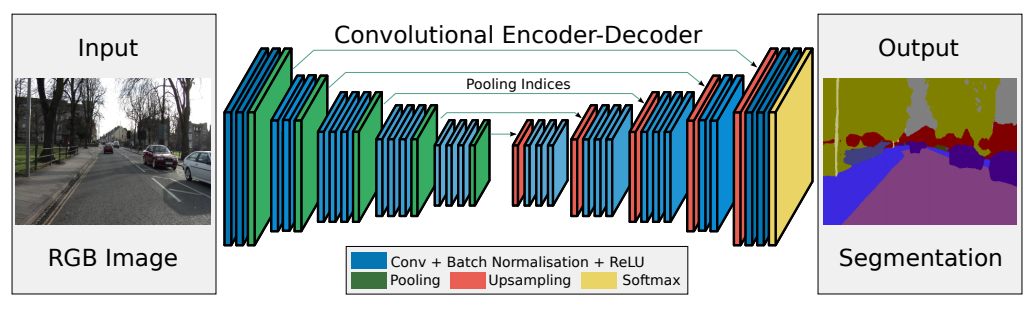

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Сначала реализуем модель SegNet для сегментации.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
import torchvision
import gc
from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

In [ ]:
vgg = torchvision.models.vgg16()
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
        )
        self.pool0 =  nn.MaxPool2d(kernel_size=(2, 2))
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )
        self.pool1 =  nn.MaxPool2d(kernel_size=(2, 2))
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2)) # 32 -> 16


        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.UpsamplingBilinear2d(scale_factor=2)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
        )
        self.upsample1 =  nn.UpsamplingBilinear2d(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )
        self.upsample2 = nn.UpsamplingBilinear2d(scale_factor=2)  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
        )
        self.upsample3 = nn.UpsamplingBilinear2d(scale_factor=2)  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.pool0(self.enc_conv0(x))
        e1 = self.pool1(self.enc_conv1(e0))
        e2 = self.pool2(self.enc_conv2(e1))
        e3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b))
        d1 = self.dec_conv1(self.upsample1(d0))
        d2 = self.dec_conv2(self.upsample2(d1))
        d3 = self.dec_conv3(self.upsample3(d2)) # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded

## Функция потерь
Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Расмотрим следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
    # TODO
    # please don't use nn.BCELoss. write it from scratch
    loss = torch.mean(y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred)))
    return loss

## Тренировка

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его, т.к. будем реализовывать разные метрики.

In [ ]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, metric):
    X_val, Y_val = next(iter(data_val))
    history = {'epoch': [],
               'train_loss': [], 'val_loss': [],
               'train_metric': [], 'val_metric': []}
    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_val_loss = 0
        avg_score = 0
        avg_val_score = 0

        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)

            # set parameter gradients to zero
            opt.zero_grad()

            # forward
            #print(X_batch.shape, Y_batch.shape)
            Y_pred = model(X_batch)
            #print(Y_pred.shape)
            loss =  loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()  # update weights

            # calculate loss to show the user
            avg_loss += loss / len(data_tr)
            avg_score += metric((torch.sigmoid(Y_pred) > 0.5).int(), Y_batch).mean().item() / len(data_tr)
            torch.cuda.empty_cache()

        toc = time()
        print('loss: %f' % avg_loss)

        model.eval()  # testing mode
        with torch.no_grad():
            for X_val_batch, Y_val_batch in data_val:
                # data to device
                X_val_batch, Y_val_batch = X_val_batch.to(device), Y_val_batch.to(device)


                Y_val_pred = model(X_val_batch)
                #print(Y_pred.shape)
                loss =  loss_fn(Y_val_batch, Y_val_pred)

                # calculate loss to show the user
                avg_val_loss += loss / len(data_val)
                avg_val_score += metric((torch.sigmoid(Y_val_pred) > 0.5).int(), Y_val_batch).mean().item() / len(data_val)
                torch.cuda.empty_cache()

        history['epoch'].append(epoch)
        history['train_loss'].append(avg_loss.item())
        history['val_loss'].append(avg_val_loss.item())
        history['train_metric'].append(avg_score)
        history['val_metric'].append(avg_val_score)
        # show intermediate results
        with torch.no_grad():
            Y_hat = model(X_val.to(device)).detach().cpu().numpy()# detach and put into cpu
            # Visualize tools
            clear_output(wait=True)
            for k in range(6):
                plt.subplot(2, 6, k+1)
                plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
                plt.title('Real')
                plt.axis('off')

                plt.subplot(2, 6, k+7)
                plt.imshow(Y_hat[k, 0] > 0, cmap='gray')
                plt.title('Output')
                plt.axis('off')
            plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
            plt.show()

    return history

In [ ]:
def plot_history(history):
    fig1, axes1 = plt.subplots(nrows=1, ncols=2)

    axes1[0].plot(history['epoch'], history['train_loss'], label='train_loss')
    axes1[0].plot(history['epoch'], history['val_loss'], label='val_loss')
    axes1[0].grid()
    axes1[0].legend()

    axes1[1].plot(history['epoch'], history['train_metric'], label='train_score')
    axes1[1].plot(history['epoch'], history['val_metric'], label='val_score')
    axes1[1].grid()
    axes1[1].legend()

## Инференс

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
def predict(model, data):
    with torch.no_grad():
        model.eval()  # testing mode
        Y_pred = [ model(X_batch.to(device)) for X_batch, _ in data]
        return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    scores = 0
    with torch.no_grad():
        model.eval()  # testing mode
        for X_batch, Y_label in data:
            Y_pred = model(X_batch.to(device))
            scores += metric(torch.sigmoid(Y_pred) > 0.5, Y_label.to(device)).mean().item()

    return scores/len(data)

## Обучение


In [ ]:
model = SegNet().to(device)

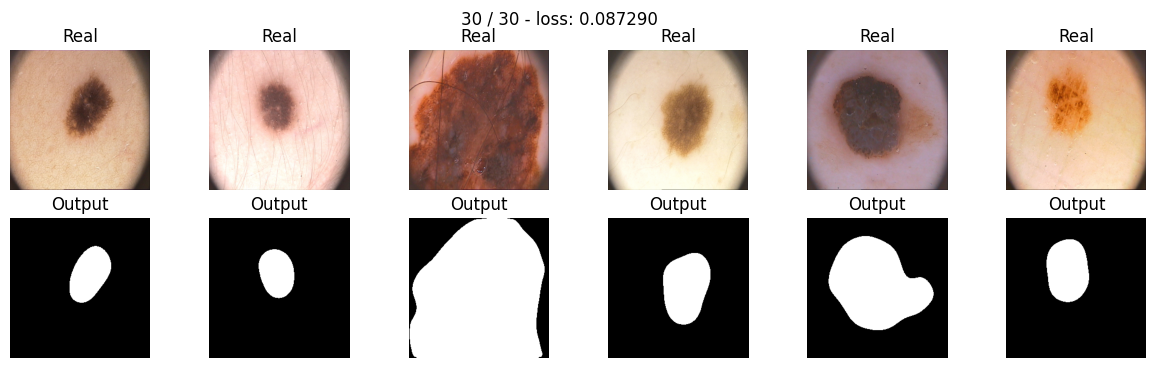

In [ ]:
max_epochs = 30
optim = torch.optim.Adam(model.parameters(), lr=3e-4)
history_seg_bce = train(model, optim, bce_loss, max_epochs, data_tr, data_val, iou_pytorch)

In [ ]:
score_seg_bce = score_model(model, iou_pytorch, data_val)

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь

Имплементируем две функции потерь:
 DICE и Focal loss.



**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$



In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    smooth = 1e-7
    union = torch.sum(y_real * y_pred) + smooth
    intersection = torch.sum(y_real + y_pred) + smooth

    return 1 - 2 * union / intersection

Проводим тестирование:

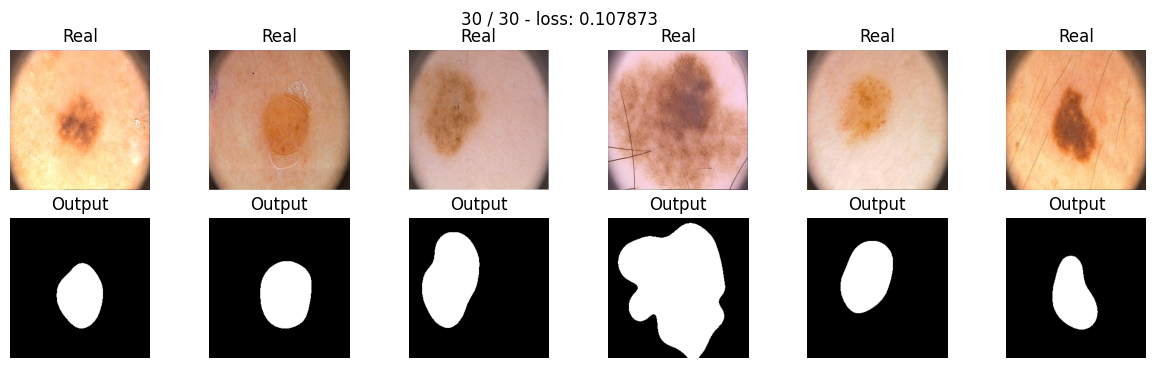

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_dice.parameters(), lr=3e-4)
history_seg_dice = train(model_dice, optimaizer, dice_loss, max_epochs, data_tr, data_val, iou_pytorch)

In [ ]:
score_seg_dice = score_model(model_dice, iou_pytorch, data_val)

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    sig = torch.clamp(torch.sigmoid(y_pred), eps, 1 - eps)
    loss =  -((1 - sig)**gamma * y_real * torch.log(sig) + (1 - y_real) * torch.log(1 - sig))
    return loss.mean()


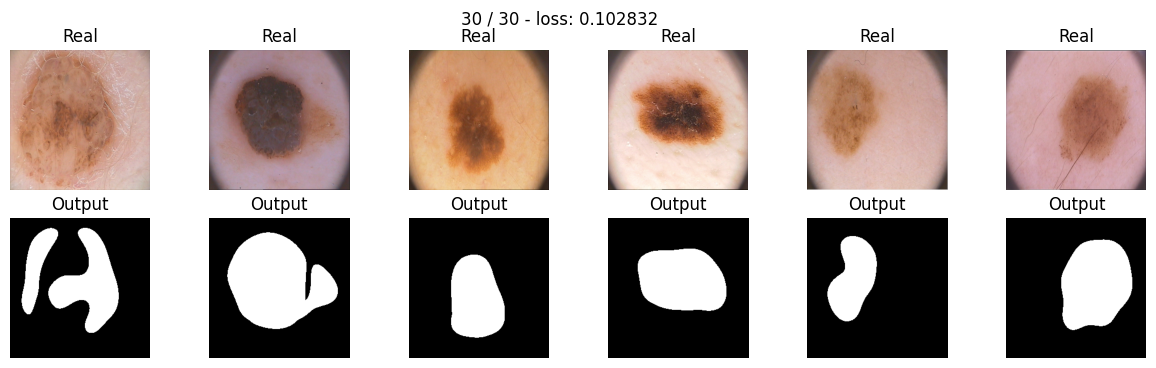

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_focal.parameters(), lr=3e-4)
history_seg_focal = train(model_focal, optimaizer, focal_loss, max_epochs, data_tr, data_val, iou_pytorch)

In [ ]:
score_seg_focal = score_model(model_focal, iou_pytorch, data_val)

----------------------------------------------------------------------------------------------

## Другие сегментационные лоссы

Будем использовать SSIM loss из статьи [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

In [ ]:
def ssim_loss(y_real, y_pred, C1=1e-7, C2=1e-7):
    x = y_real
    y = torch.sigmoid(y_pred)

    mean_x = torch.mean(x)
    mean_y = torch.mean(y)

    var_x = torch.var(x)
    var_y = torch.var(y)

    cov_xy = torch.mean((x - mean_x) * (y - mean_y))

    num = (2 * mean_x * mean_y + C1) * (2 * cov_xy + C2)
    den = (mean_x**2 + mean_y**2 + C1) * (var_x + var_y + C2)

    ssim = num / den

    return 1 - ssim

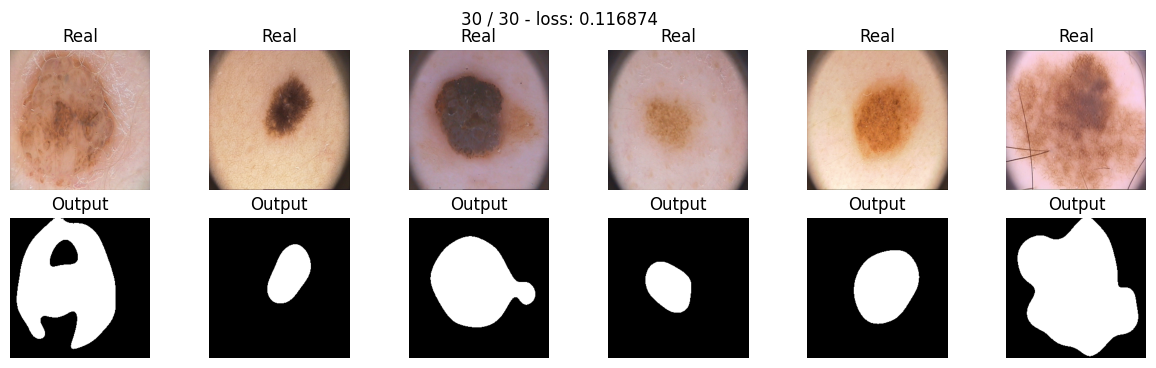

In [ ]:
model_ssim = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_ssim.parameters(), lr=3e-4)
history_seg_ssim = train(model_ssim, optimaizer, ssim_loss, max_epochs, data_tr, data_val, iou_pytorch)

In [ ]:
score_seg_ssim = score_model(model_ssim, iou_pytorch, data_val)

Напишем еще Tversky loss
* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

In [ ]:
def tversky_loss(y_real, y_pred, alpha=0.8, smooth=1e-8):
  y_pred = torch.sigmoid(y_pred)
  num = torch.sum(y_real * y_pred)
  den = torch.sum(y_real + y_pred)
  b1 = torch.sum(torch.abs(y_real) * (1 - y_pred))
  b2 = torch.sum(torch.abs(y_pred) * (1 - y_real))
  res = -(num + smooth) / (num + alpha * b1 + (1 - alpha) * b2 + smooth)
  return res

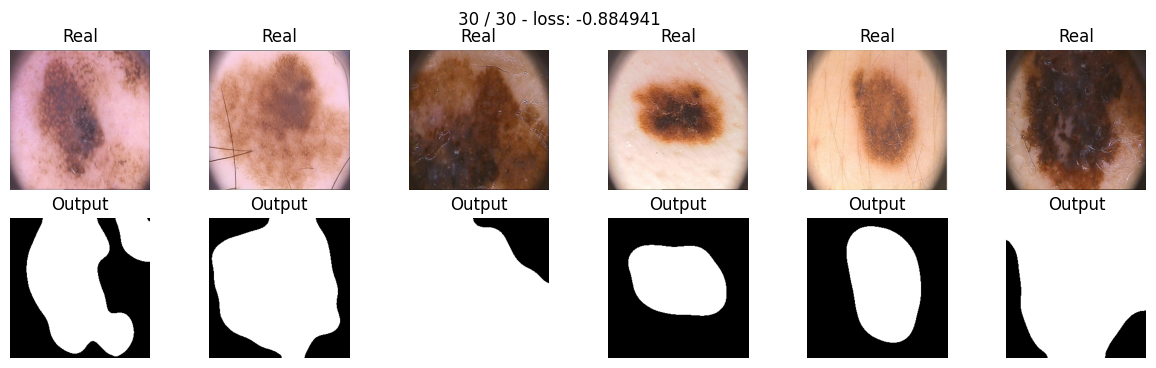

In [ ]:
model_tvr = SegNet().to(device)

max_epochs = 30
optimaizer = torch.optim.Adam(model_tvr.parameters(), lr=3e-4)
history_seg_tvr = train(model_tvr, optimaizer, tversky_loss, max_epochs, data_tr, data_val, iou_pytorch)

In [ ]:
score_seg_tvr = score_model(model_tvr, iou_pytorch, data_val)

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее и будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

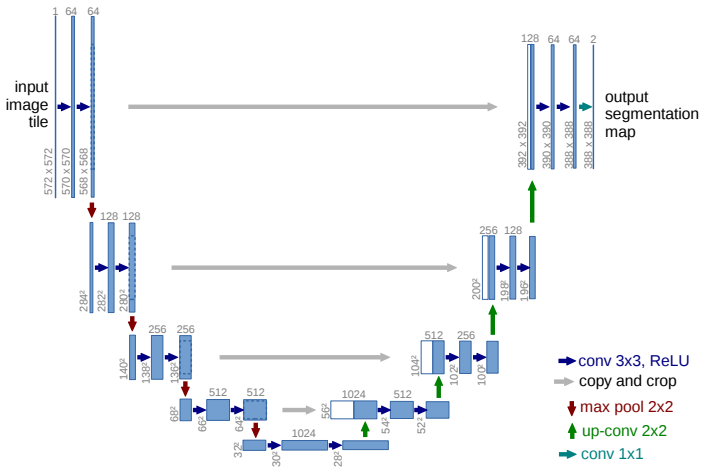

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
        )
        self.pool0 =  nn.MaxPool2d(kernel_size=(2, 2))
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )
        self.pool1 =  nn.MaxPool2d(kernel_size=(2, 2))
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.MaxPool2d(kernel_size=(2, 2)) # 32 -> 16


        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1)
        )
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
        )
        self.upsample1 =  nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        ) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )
        self.upsample2 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1)
        )  # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
        )
        self.upsample3 = nn.Sequential(
            nn.UpsamplingBilinear2d(scale_factor=2),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1)
        )  # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)
        # bottleneck
        b = self.bottleneck_conv(p3)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1)) # no activation
        return d3

In [ ]:
unet_model = UNet().to(device)

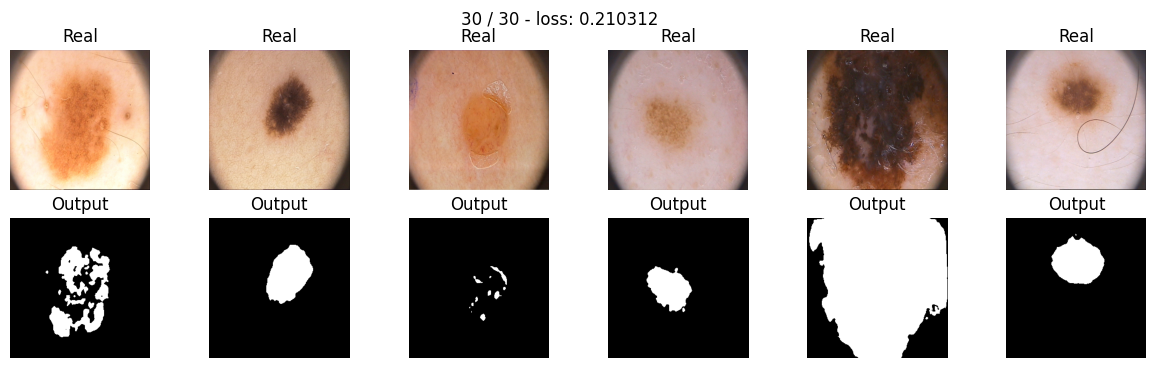

In [ ]:
history_unet_bce = train(unet_model, torch.optim.Adam(unet_model.parameters(), lr=3e-4), bce_loss, 30, data_tr, data_val, iou_pytorch)

In [ ]:
score_unet_bce = score_model(unet_model, iou_pytorch, data_val)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)



In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
        )
        self.pool0 =  nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )
        self.pool1 =  nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
        )
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1)


        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True)
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=512),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
        )
        self.upsample1 =  nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)
        # bottleneck
        b = self.bottleneck_conv(p3)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1)) # no activation
        return d3

In [ ]:
unet2_model = UNet2().to(device)


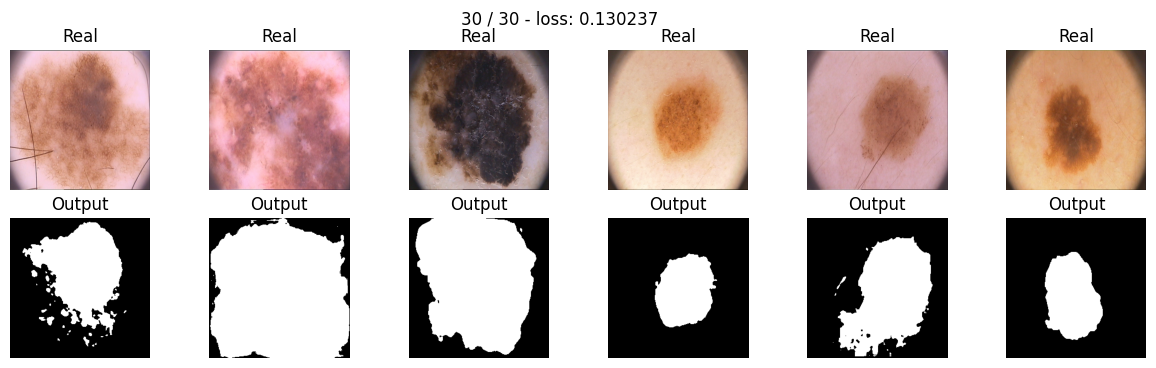

In [ ]:
history_unet2_bce = train(unet2_model, torch.optim.Adam(unet2_model.parameters(), lr=3e-4), bce_loss, 30, data_tr, data_val, iou_pytorch)

In [ ]:
score_unet2_bce = score_model(unet2_model, iou_pytorch, data_val)

#Выведем все графики лоссов и метрик для каждой модели

In [ ]:
import pandas as pd
compare = pd.DataFrame({'model' : [],
                        'loss' : [],
                        'score' : []})

* SegNet + BCE

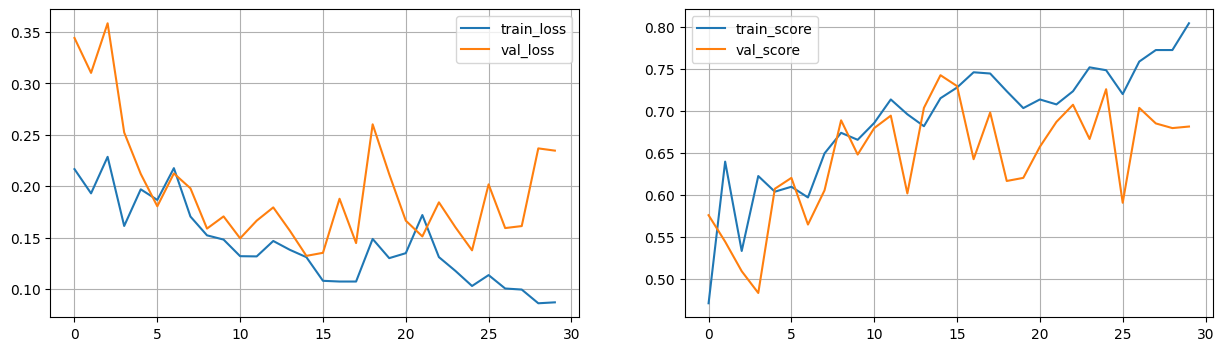

In [ ]:
plot_history(history_seg_bce)

In [ ]:
print(f'score SegNet + BCE = {score_seg_bce}')
compare = compare.append({'model' : 'SegNet', 'loss' : 'BCE', 'score' : score_seg_bce}, ignore_index=True)

score SegNet + BCE = 0.6925926076041328


<ipython-input-49-56799eb6b5ea>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model' : 'SegNet', 'loss' : 'BCE', 'score' : score_seg_bce}, ignore_index=True)


* SegNet + DiceLoss

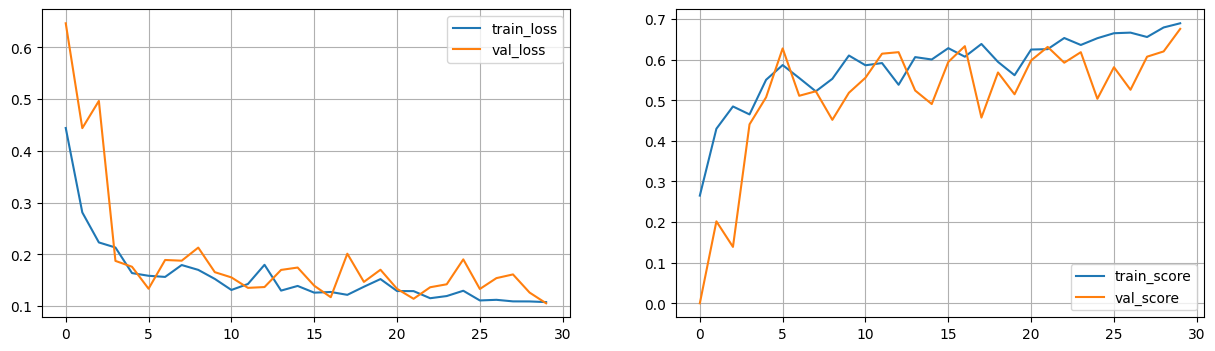

In [ ]:
plot_history(history_seg_dice)

In [ ]:
print(f'score SegNet + DiceLoss = {score_seg_dice}')
compare = compare.append({'model' : 'SegNet', 'loss' : 'Dice', 'score' : score_seg_dice}, ignore_index=True)

score SegNet + DiceLoss = 0.6796296570036147


<ipython-input-51-f2f853c95396>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model' : 'SegNet', 'loss' : 'Dice', 'score' : score_seg_dice}, ignore_index=True)


* SegNet + FocalLoss

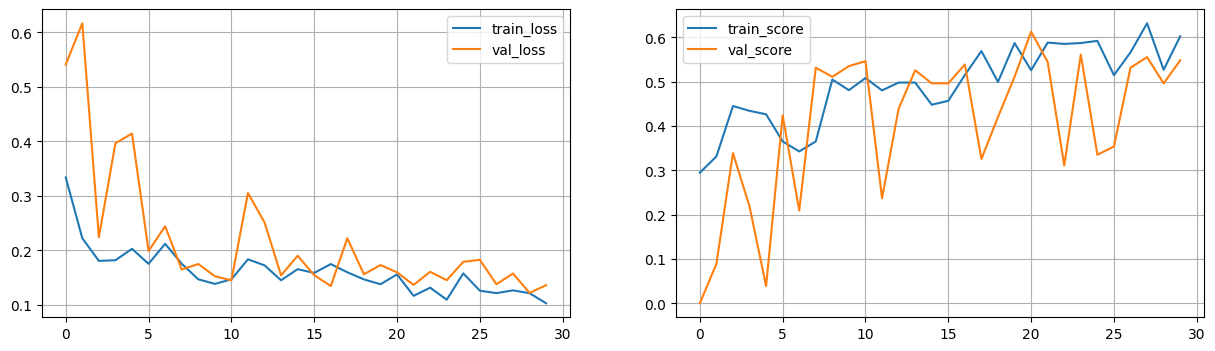

In [ ]:
plot_history(history_seg_focal)

In [ ]:
print(f'score SegNet + FocalLoss = {score_seg_focal}')
compare = compare.append({'model' : 'SegNet', 'loss' : 'Focal', 'score' : score_seg_focal}, ignore_index=True)

score SegNet + FocalLoss = 0.5407407614919875


<ipython-input-53-642423c1b2e8>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model' : 'SegNet', 'loss' : 'Focal', 'score' : score_seg_focal}, ignore_index=True)


* SegNet + SSIM

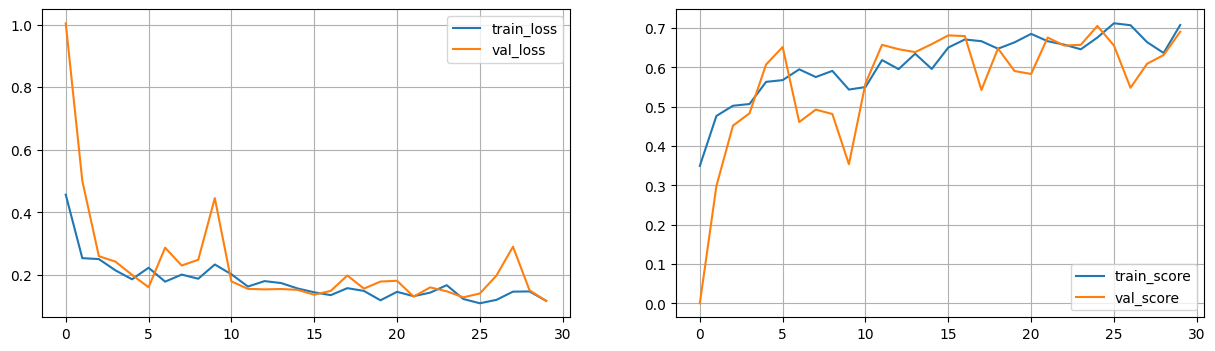

In [ ]:
plot_history(history_seg_ssim)

In [ ]:
print(f'score SegNet + SSIMLoss = {score_seg_ssim}')
compare = compare.append({'model' : 'SegNet', 'loss' : 'SSIM', 'score' : score_seg_ssim}, ignore_index=True)

score SegNet + SSIMLoss = 0.6944444643126594


<ipython-input-55-4107ef2656bc>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model' : 'SegNet', 'loss' : 'SSIM', 'score' : score_seg_ssim}, ignore_index=True)


* SegNet + TverskyLoss

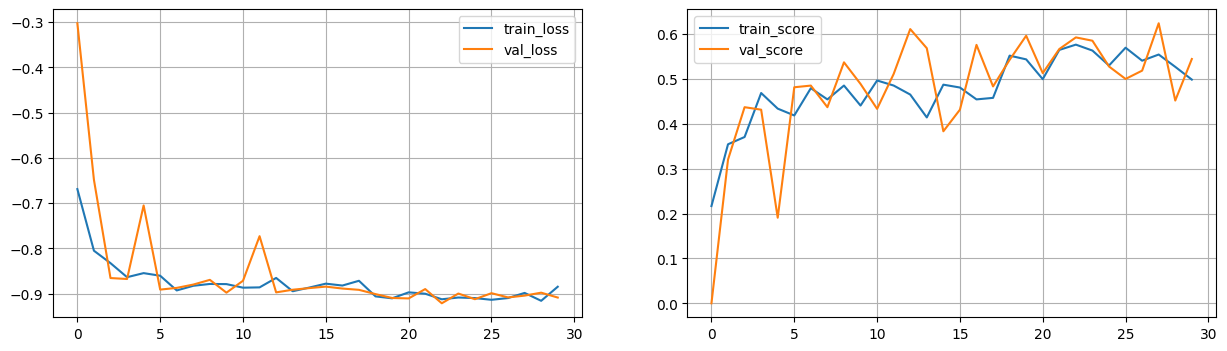

In [ ]:
plot_history(history_seg_tvr)

In [ ]:
print(f'score SegNet + TverskyLoss = {score_seg_tvr}')
compare = compare.append({'model' : 'SegNet', 'loss' : 'Tversky', 'score' : score_seg_tvr}, ignore_index=True)

score SegNet + TverskyLoss = 0.5444444484180875


<ipython-input-57-c83ee17fc343>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model' : 'SegNet', 'loss' : 'Tversky', 'score' : score_seg_tvr}, ignore_index=True)


* UNet + BCE

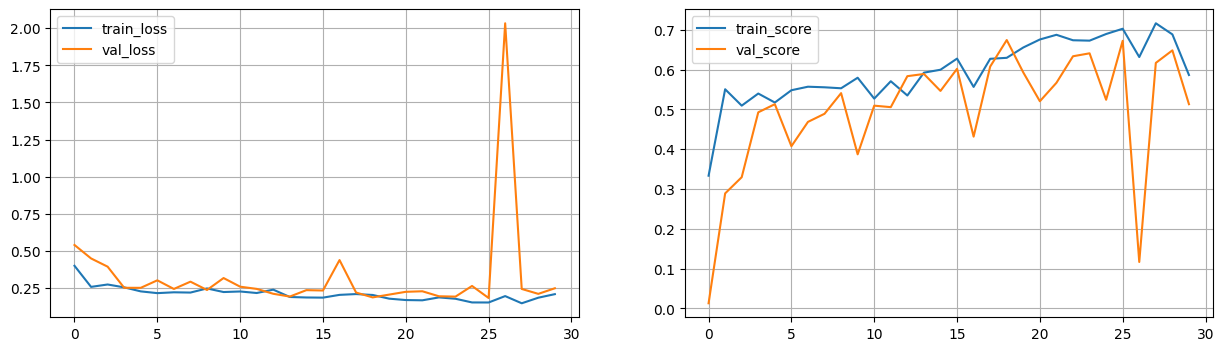

In [ ]:
plot_history(history_unet_bce)

In [ ]:
print(f'score UNet + BceLoss = {score_unet_bce}')
compare = compare.append({'model' : 'UNet', 'loss' : 'BCE', 'score' : score_unet_bce}, ignore_index=True)

score UNet + BceLoss = 0.5277777877118852


<ipython-input-59-ccdf1932e1ad>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model' : 'UNet', 'loss' : 'BCE', 'score' : score_unet_bce}, ignore_index=True)


* UNet2 + BCE

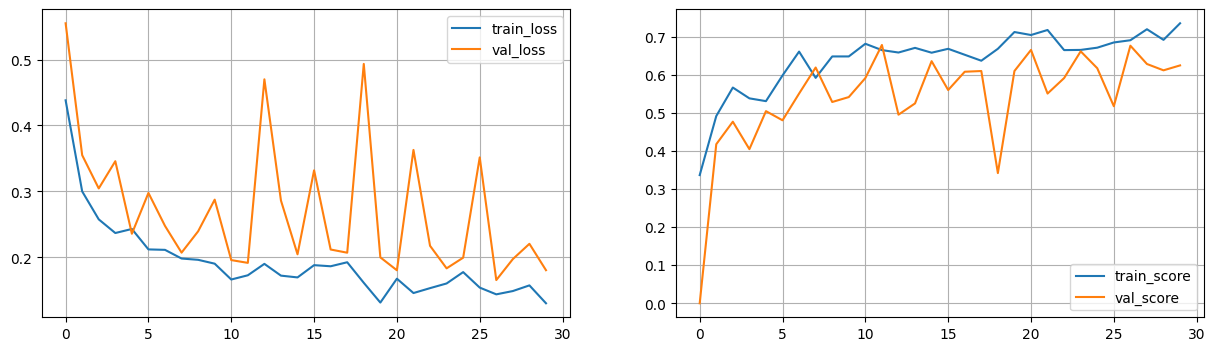

In [ ]:
plot_history(history_unet2_bce)

In [ ]:
print(f'score UNet2 + BceLoss = {score_unet2_bce}')
compare = compare.append({'model' : 'UNet2', 'loss' : 'BCE', 'score' : score_unet2_bce}, ignore_index=True)

score UNet2 + BceLoss = 0.6222222513622708


<ipython-input-61-0db9f559d36d>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  compare = compare.append({'model' : 'UNet2', 'loss' : 'BCE', 'score' : score_unet2_bce}, ignore_index=True)


In [ ]:
compare

,model,loss,score
0,SegNet,BCE,0.692593
1,SegNet,Dice,0.679630
2,SegNet,Focal,0.540741
3,SegNet,SSIM,0.694444
4,SegNet,Tversky,0.544444
5,UNet,BCE,0.527778
6,UNet2,BCE,0.622222


Судя по первым двум графикам модель могла переобучится. Почти все модели за свое количество эпох сошлись желаемому минимуму функции.

Самая лучшая реализация SegNet с использованием SSIM loss.